# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [74]:
# Load pickled data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import Augmentor
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import glob
import cv2
import json
import time
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

np.set_printoptions(suppress=True)

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print('Got the data!')

Got the data!


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
print('Train shape: ', X_train.shape)
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
IMAGE_SHAPE = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", IMAGE_SHAPE)
print("Number of classes =", n_classes)

Train shape:  (34799, 32, 32, 3)
Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [3]:
label_map = {
  0: 'Speed limit (20km/h)',
  1: 'Speed limit (30km/h)',
  2: 'Speed limit (50km/h)',
  3: 'Speed limit (60km/h)',
  4: 'Speed limit (70km/h)',
  5: 'Speed limit (80km/h)',
  6: 'End of speed limit (80km/h)',
  7: 'Speed limit (100km/h)',
  8: 'Speed limit (120km/h)',
  9: 'No passing',
  10: 'No passing for vehicles over 3.5 metric tons',
  11: 'Right-of-way at the next intersection',
  12: 'Priority road',
  13: 'Yield',
  14: 'Stop',
  15: 'No vehicles',
  16: 'Vehicles over 3.5 metric tons prohibited',
  17: 'No entry',
  18: 'General caution',
  19: 'Dangerous curve to the left',
  20: 'Dangerous curve to the right',
  21: 'Double curve',
  22: 'Bumpy road',
  23: 'Slippery road',
  24: 'Road narrows on the right',
  25: 'Road work',
  26: 'Traffic signals',
  27: 'Pedestrians',
  28: 'Children crossing',
  29: 'Bicycles crossing',
  30: 'Beware of ice/snow',
  31: 'Wild animals crossing',
  32: 'End of all speed and passing limits',
  33: 'Turn right ahead',
  34: 'Turn left ahead',
  35: 'Ahead only',
  36: 'Go straight or right',
  37: 'Go straight or left',
  38: 'Keep right',
  39: 'Keep left',
  40: 'Roundabout mandatory',
  41: 'End of no passing',
  42: 'End of no passing by vehicles over 3.5 metric tons',
}

def label(label_id):
    '''
    Given a label id, return the name
    '''
    return label_map[label_id]
    

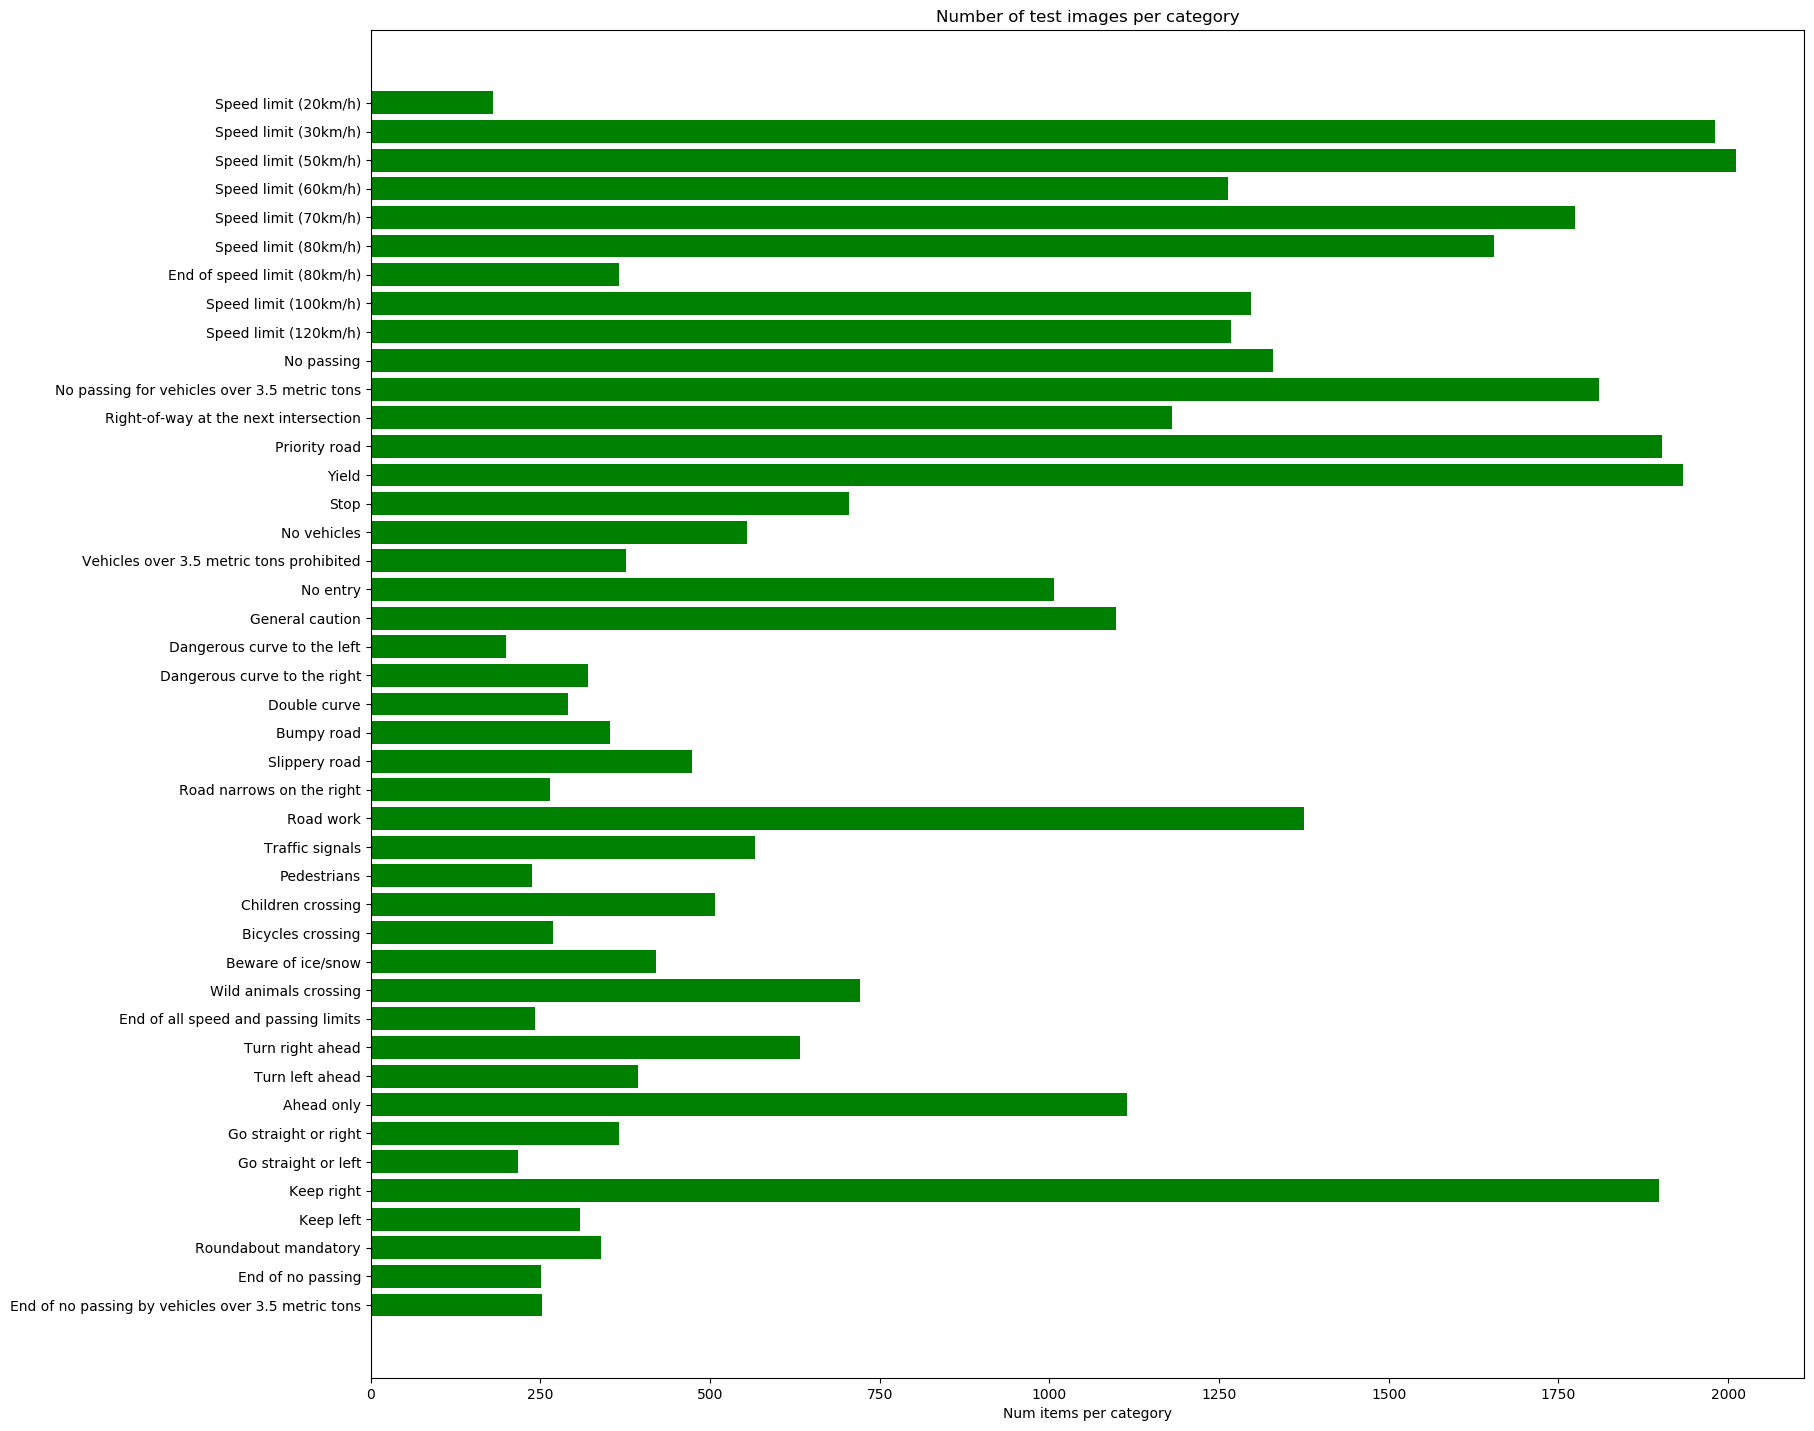

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
# Example data
categories = label_map.values()
y_pos = np.arange(len(categories))
num_per_category = {y:x for x,y in label_map.items()}
for i in y_train:
    num_per_category[label(i)] += 1

ax.barh(y_pos, num_per_category.values(), align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(categories)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Num items per category')
ax.set_title('Number of test images per category')
fig.set_size_inches(18.5, 17.5)

plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

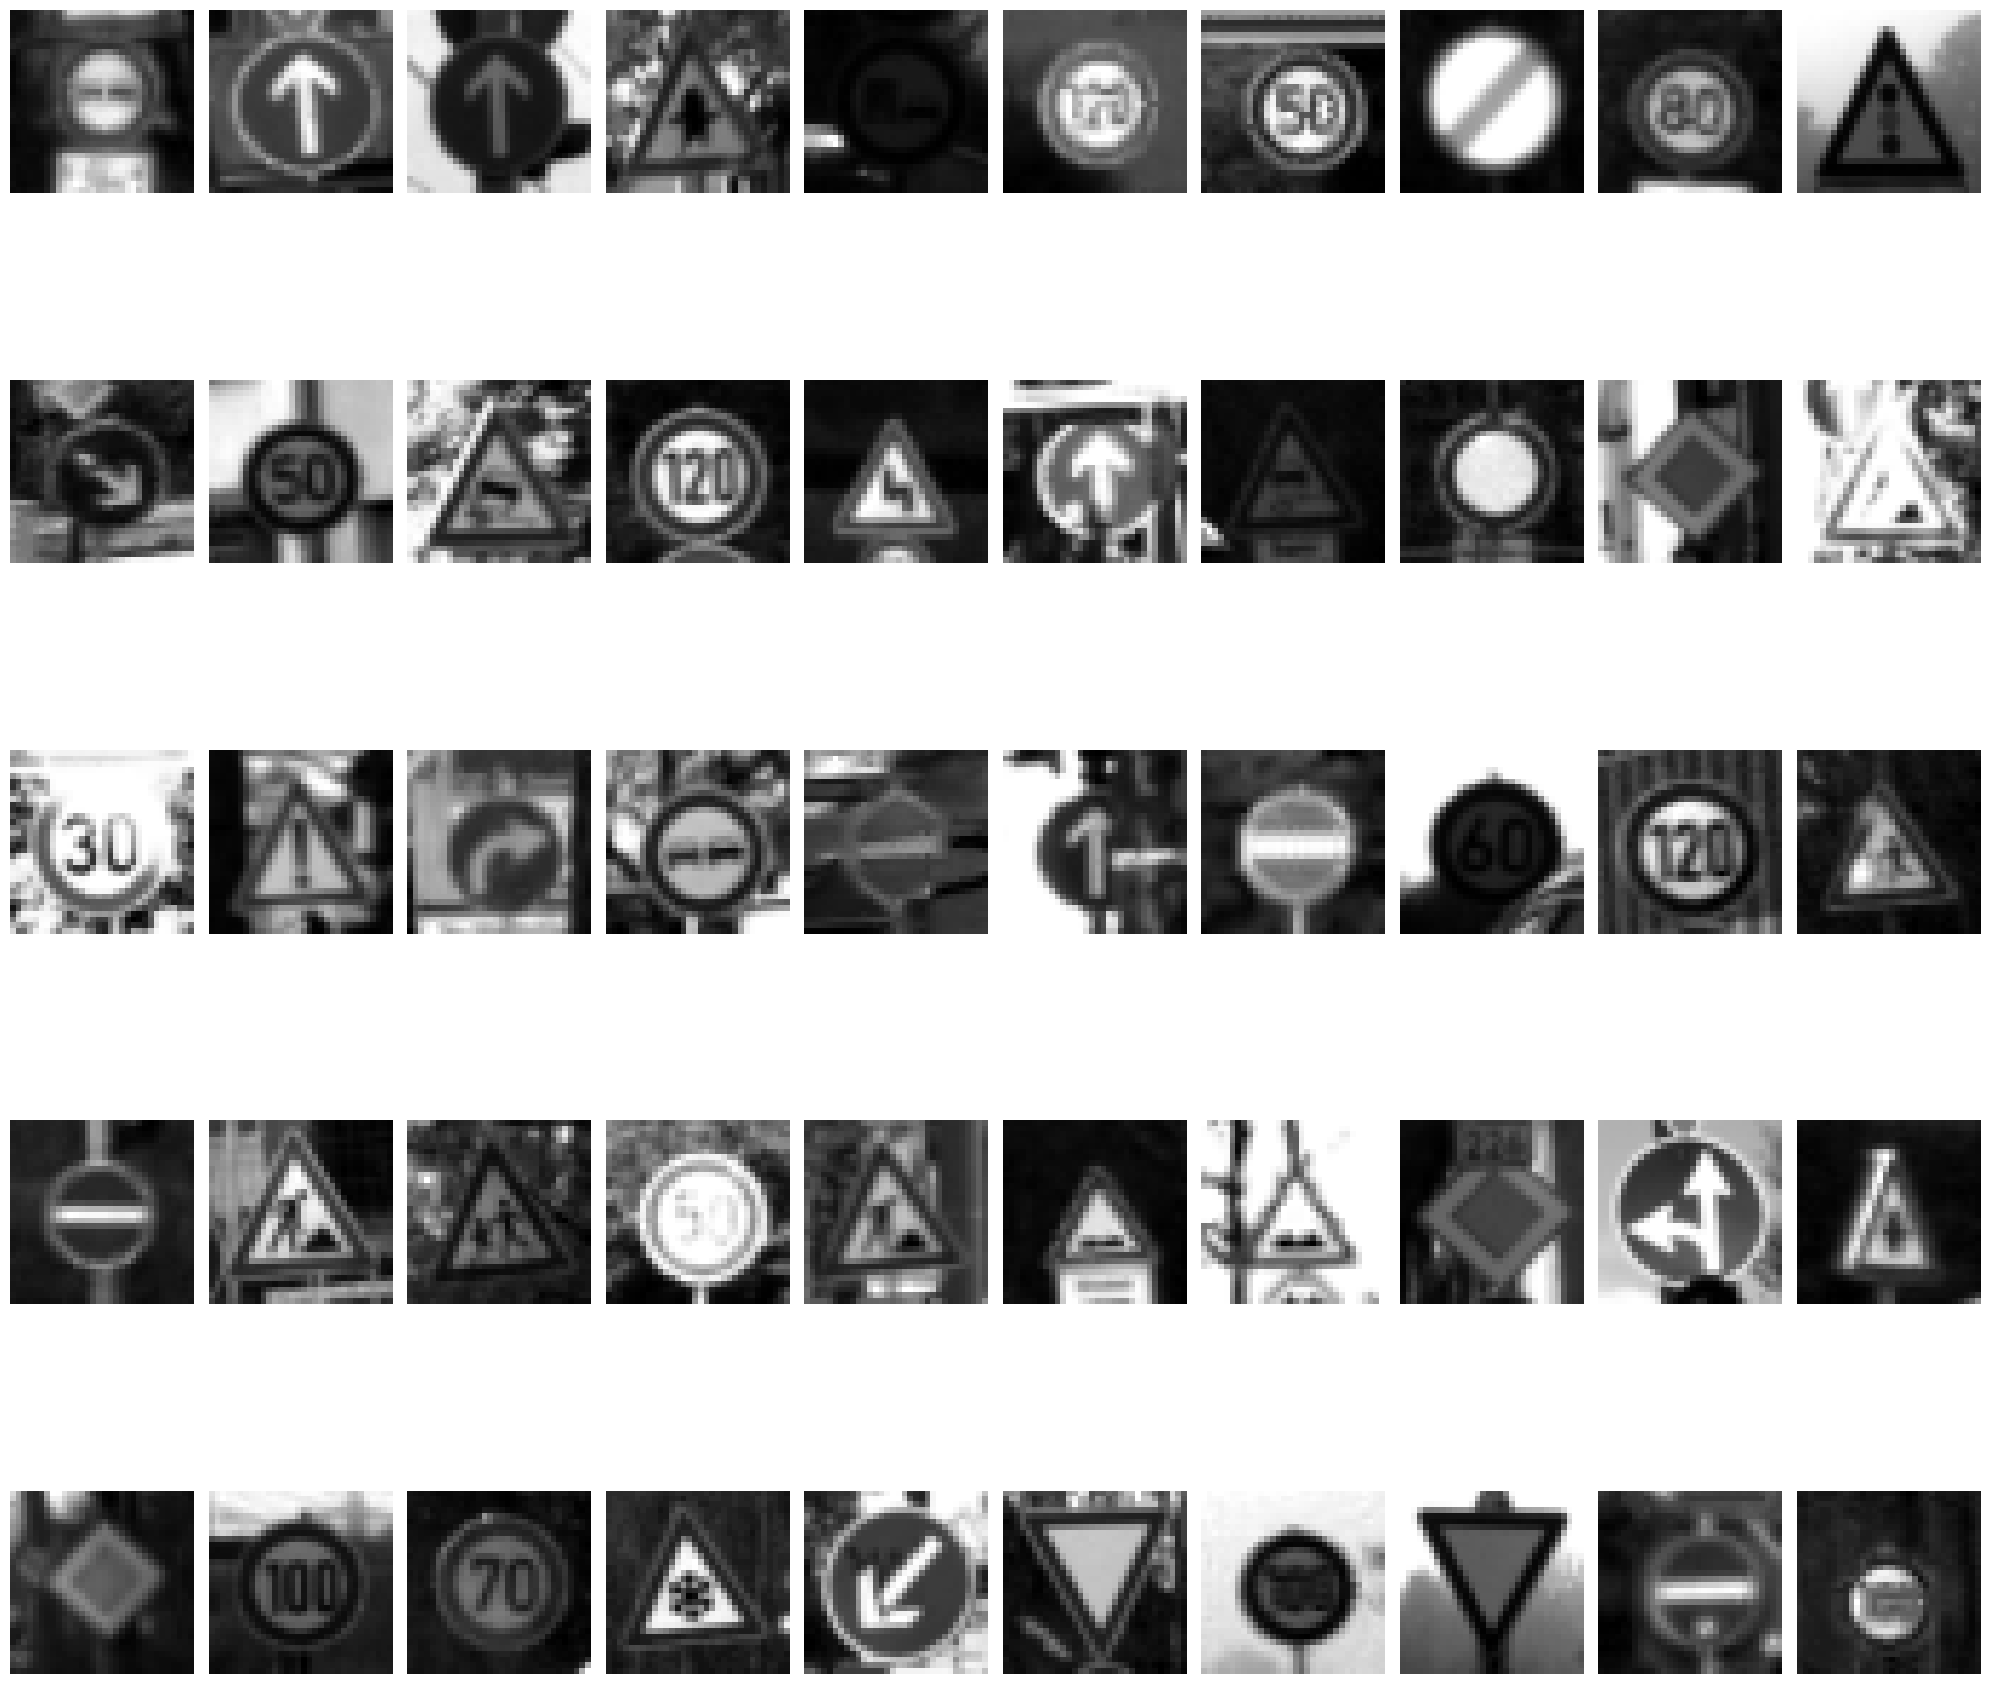

In [54]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def normalize_image(image):
    '''
    Preprocesses a single image
    '''
    if image.shape != IMAGE_SHAPE:
        image = cv2.resize(image, dsize=IMAGE_SHAPE[0:2], interpolation=cv2.INTER_CUBIC)

    # convert to grayscale image
    image = np.array(image / 255.0, dtype=np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image.reshape(32,32,1)



def preprocess(x, y, normalize=True, augment=False):
    '''
    Preprocesses the data
    '''
    x, y = shuffle(x, y)
    
    if normalize:
        normalized_images = []
        for input_image in x:
            normalized_images.append(normalize_image(input_image))
            
        x = normalized_images

    if augment:
        p = Augmentor.DataPipeline(list(x), list(y))
        p.zoom_random(1, percentage_area=0.9)
        p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
        p.skew(0.8, 0.1)
        p.shear(0.5, 1, 1)
        p.random_erasing(0.1, 0.12)
        p.random_contrast(0.5, 0.4, 1.0)
        p.random_color(0.5, 0.6, 1.0)
        p.random_brightness(0.5, 0.8, 1.0)
        p.greyscale(0.2)
        x, y = p.sample(len(x))
    return x, y


example_x, example_y = preprocess(X_train, y_train)


def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(np.squeeze(figures[title], axis=2), cmap='gray')
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional



# generation of a dictionary of (title, images)
number_of_im = 50
w=32
h=32
figures = {'im'+str(i): example_x[i] for i in range(number_of_im)}

# plot of the images in a figure, with 5 rows and 4 columns
plot_figures(figures, 5, 10)

plt.show()


### Model Architecture

In [96]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x10.
    # new_height = (input_height - filter_height + 2 * P)/S + 1
    # new_width = (input_width - filter_width + 2 * P)/S + 1
    # new_height = (32 - 5 + 2 * 1) /1 + 1 = 30 
    # new_width = (32 - 5 + 2 * 1) /1 + 1  = 30
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 30), mean=mu, stddev=sigma))
    conv1_B = tf.Variable(tf.zeros(30))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_B
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1 = tf.nn.batch_normalization(conv1, mean=0, variance=0.1, offset=0, scale=1, variance_epsilon=1)
    
    # Layer 2: Convolutional. Output = 10x10x20.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 30, 60), mean=mu, stddev=sigma))
    conv2_B = tf.Variable(tf.zeros(60))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1,1,1,1], padding='VALID') + conv2_B
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.batch_normalization(conv2, mean=0, variance=0.1, offset=0, scale=1, variance_epsilon=1)

    # Pooling. Input = 10x10x16. Output = 5x5x20.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding='VALID')

    # Flatten. Input = 5x5x30. Output = 500.
    fc0 = flatten(conv2)
    
    # Add dropout
    dropped = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 3: Fully Connected. Input = 500. Output = 200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1500, 200), mean=mu, stddev=sigma))
    fc1_B = tf.Variable(tf.zeros(200))
    fc1 = tf.matmul(dropped, fc1_W) + fc1_B

    # Activation.
    fc1 = tf.nn.relu(fc1)
    
    # Layer 4: Fully Connected. Input = 200. Output = 120.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(200, 120), mean=mu, stddev=sigma))
    fc2_B = tf.Variable(tf.zeros(120))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_B

    # Activation.
    fc2 = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 120. Output = n_classes.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(120, n_classes), mean=mu, stddev=sigma))
    fc3_B = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_B

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [88]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='input_x')
y = tf.placeholder(tf.int32, (None), name='label_y')
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = preprocess(X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE])
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



In [97]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        shuffled_x, shuffled_y = shuffle(X_train, y_train)
        train_features, train_sample_features, train_labels, train_sample_labels = train_test_split(
            shuffled_x, shuffled_y, test_size=0.1, random_state=int(time.time()))
        num_examples = len(train_features)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = preprocess(train_features[offset:end], train_labels[offset:end])
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        training_accuracy = evaluate(train_sample_features, train_sample_labels)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.795
Validation Accuracy = 0.744

EPOCH 2 ...
Training Accuracy = 0.924
Validation Accuracy = 0.861

EPOCH 3 ...
Training Accuracy = 0.957
Validation Accuracy = 0.928

EPOCH 4 ...
Training Accuracy = 0.967
Validation Accuracy = 0.931

EPOCH 5 ...
Training Accuracy = 0.977
Validation Accuracy = 0.929

EPOCH 6 ...
Training Accuracy = 0.988
Validation Accuracy = 0.954

EPOCH 7 ...
Training Accuracy = 0.986
Validation Accuracy = 0.951

EPOCH 8 ...
Training Accuracy = 0.988
Validation Accuracy = 0.943

EPOCH 9 ...
Training Accuracy = 0.991
Validation Accuracy = 0.959

EPOCH 10 ...
Training Accuracy = 0.992
Validation Accuracy = 0.960

Model saved


---

## Step 3: Test Step

Test how well the model does on the test dataset.

In [98]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.941


---

## Step 4: Test a Model on New Images

In [91]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

import glob
import cv2
import json
np.set_printoptions(suppress=True)
image_paths = glob.glob('./german_signs/sign*.png')

original_images = []
features = []
labels = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_images.append(image)
    features.append(normalize_image(image))
    
    label_id = int(image_path.split('_id_')[1].split('.')[0])
    labels.append(label_id)

features = np.asarray(features)
labels = np.asarray(labels)

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: features, y: labels, keep_prob: 1.0})
    accuracy = sess.run(accuracy_operation, feed_dict={x: features, y: labels, keep_prob: 1.0})
    print('accuracy: ', accuracy)
    top_k_probs = sess.run(top_k, feed_dict={x: features, keep_prob: 1.0})
    print('top_k_probs: ', top_k_probs)

INFO:tensorflow:Restoring parameters from ./lenet
accuracy:  1.0
top_k_probs:  TopKV2(values=array([[0.9994435 , 0.00023982, 0.00019988],
       [0.9999782 , 0.00002181, 0.00000002],
       [0.99999714, 0.00000146, 0.000001  ],
       [0.9999995 , 0.00000047, 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ]], dtype=float32), indices=array([[14, 38, 33],
       [18, 27, 26],
       [12, 40, 15],
       [25, 31, 21],
       [38, 28, 40],
       [33, 35,  1]]))


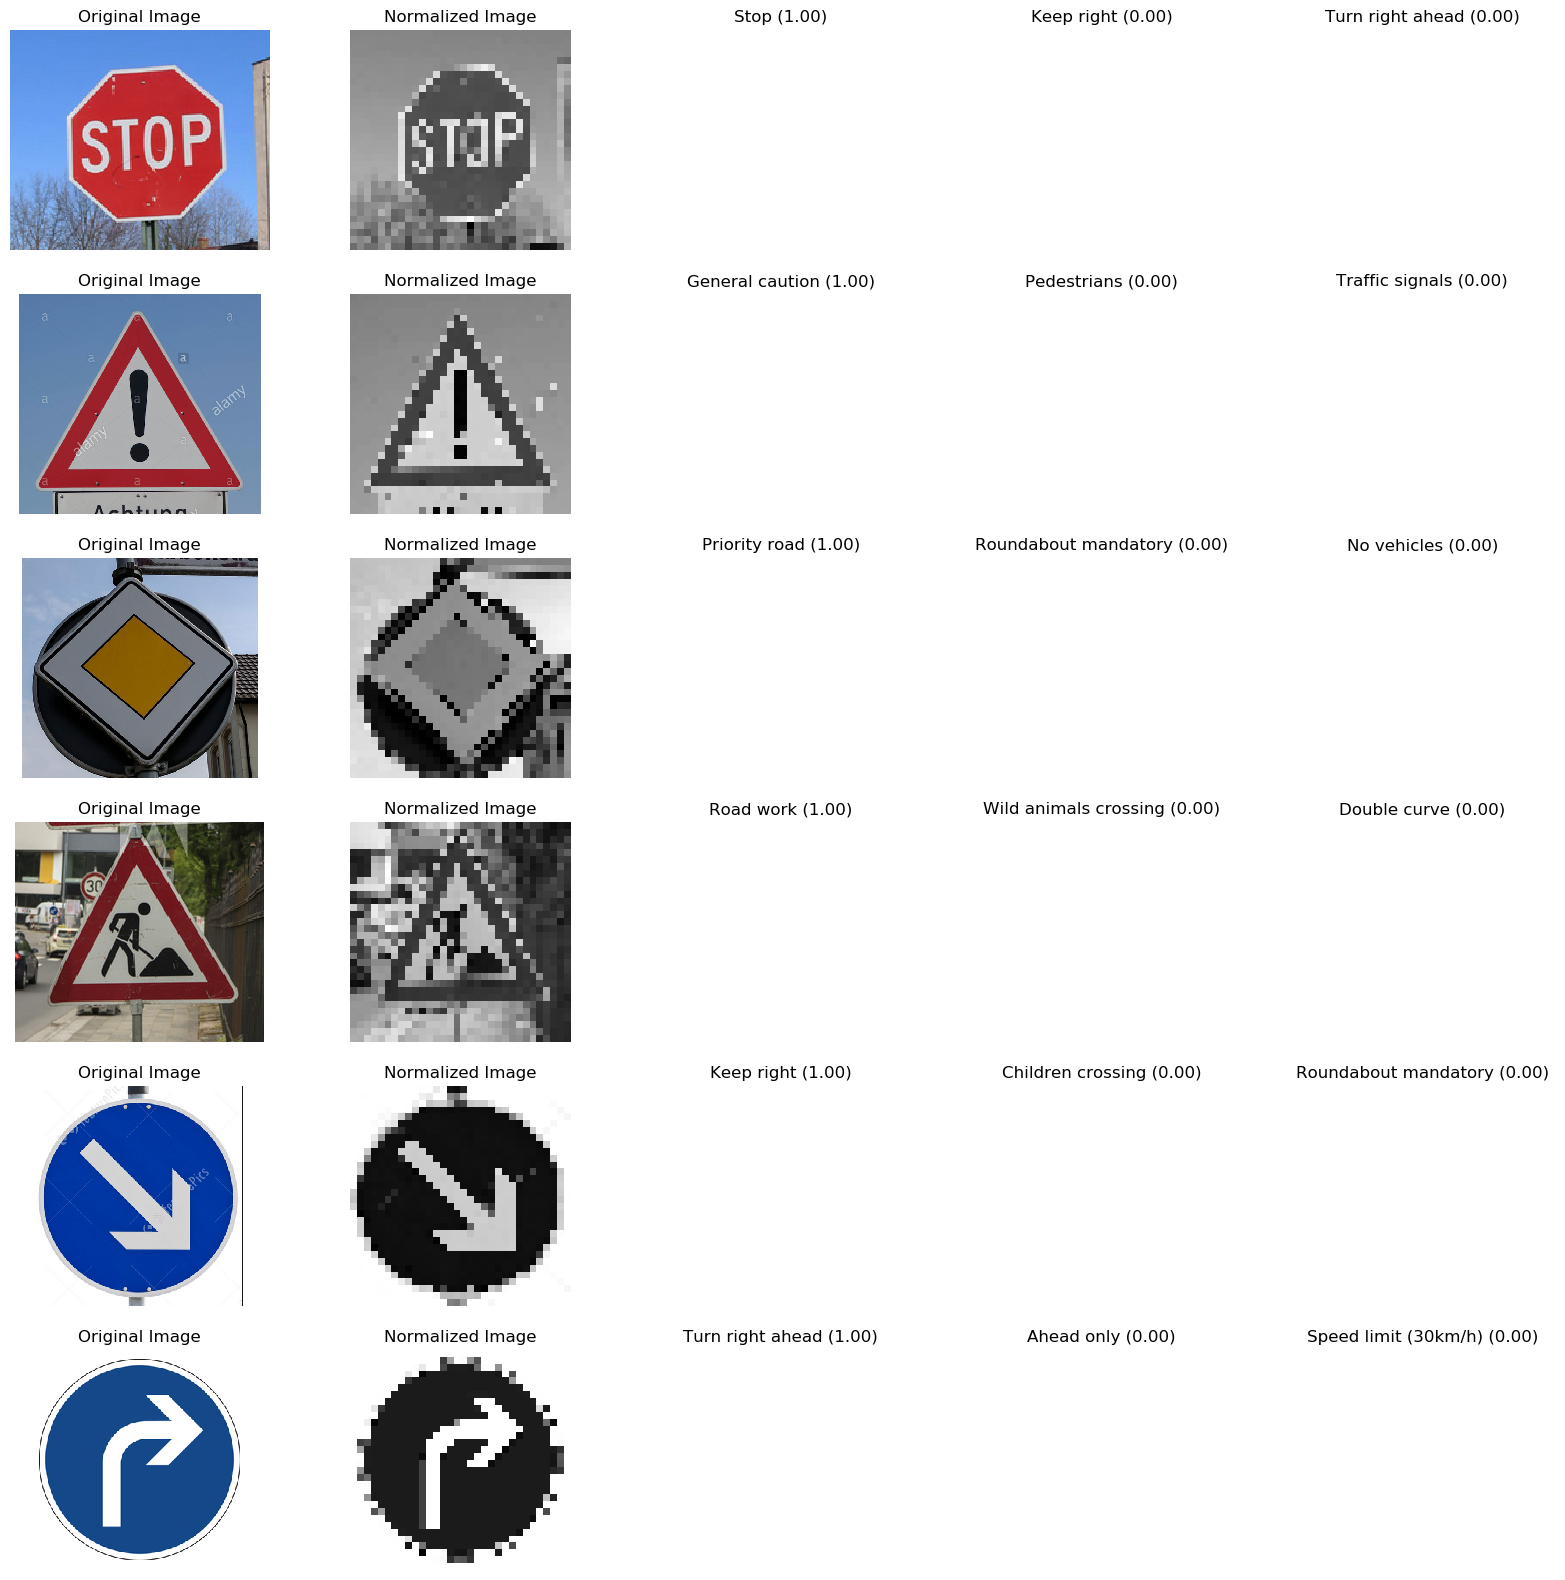

In [99]:
def visualize_top_k(original_images, input_images, top_k_probs):
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    ncols = len(top_k_probs.values[0]) + 2
    nrows = len(top_k_probs.values)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols)

    for i, img in enumerate(original_images):
        # remove axis
        for c in range(ncols):
            axes[i][c].axis('off')

        # show the given image
        cur = axes[i][0]
        cur.imshow(img)
        cur.set_title('Original Image')
        
        # Show the input image that is normalized
        cur = axes[i][1]
        cur.imshow(np.squeeze(input_images[i], axis=2), cmap='gray')
        cur.set_title('Normalized Image')
        
        # show the top five softmax prob
        for j, prob in enumerate(top_k_probs.values[i]):
            cur = axes[i][j + 2]
            class_idx = top_k_probs.indices[i][j]
            cur.set_title("{} ({:.2f})".format(label(class_idx), prob))

visualize_top_k(original_images, features, top_k_probs)